# Non linear model ($L_e(d), Bl(d), K_m(d)$)

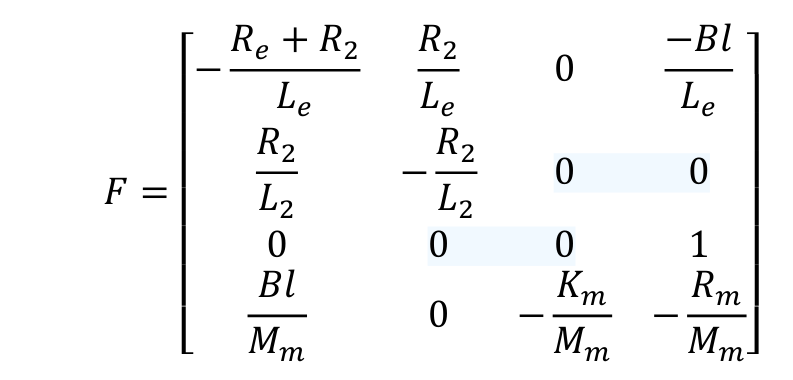

- valg af fs ud fra F?
- 

## Euler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 13027.62
fs: 65138
len samples: 325690
nperseg = 21712.666666666668
len seconds: 5.0
Num avg: 30.000921149594696
freq res: 3.0000921149594695


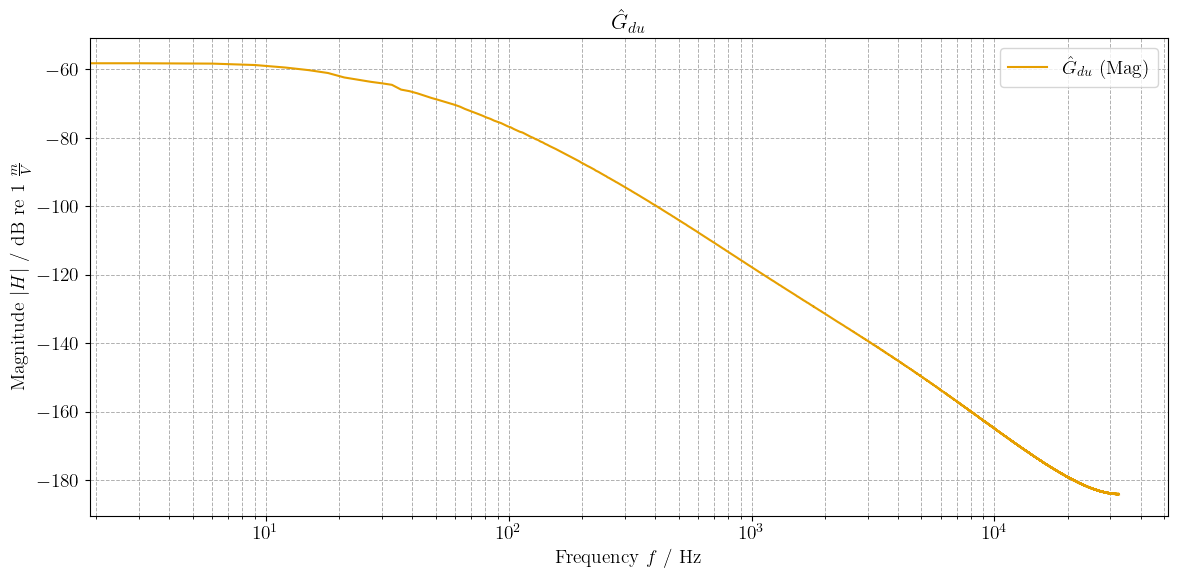

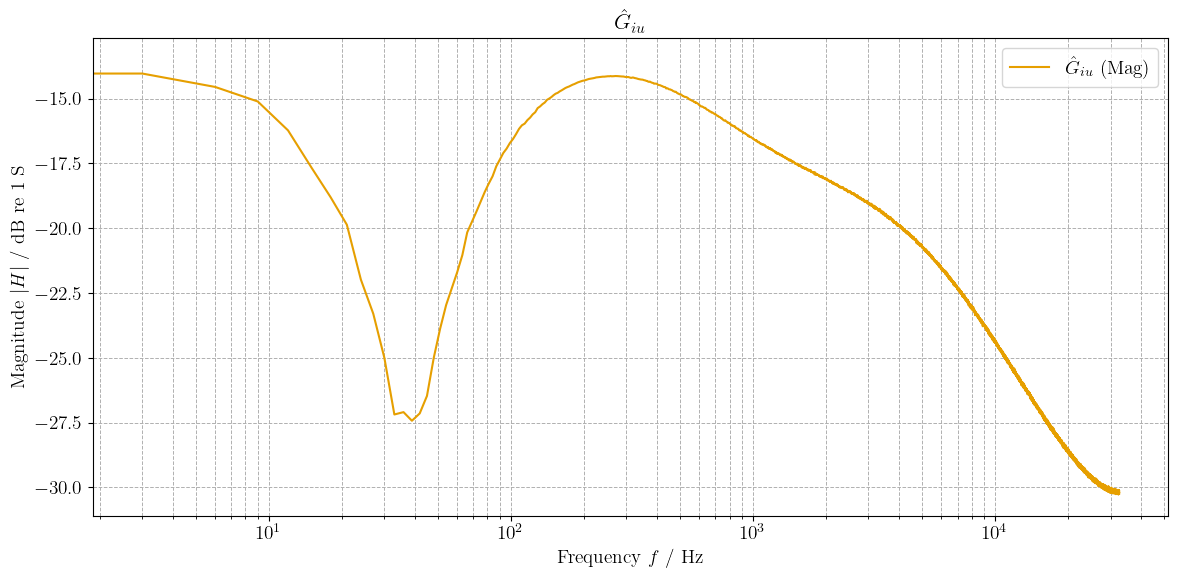

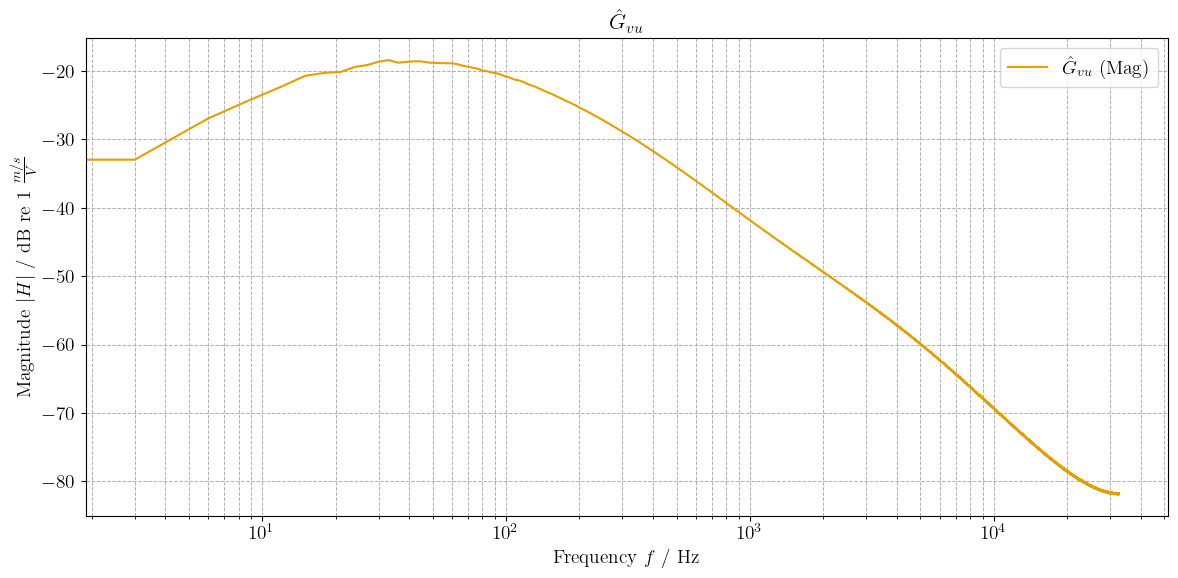

In [ ]:
%load_ext autoreload
%autoreload 2
import util
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np 
import engutil


def solve_nonlinear_euler(u_signal, x0, fs, params, polys):
    """
    params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20

}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

where poly_Bl =poly_Bl = np.poly1d(Bln)

    """
    Ts = 1.0 / fs
    num_steps = len(u_signal)
    num_states = len(x0)
    
    # output:
    x_history = np.zeros((num_steps, num_states))
    x_curr = x0.copy()
    
    # static values
    Re = params['Re']
    R20 = params['R20']
    L20 = params['L20']
    Mm = params['Mm']
    Rm = params['Rm']
    
    # init matrices
    F = np.zeros((4, 4))
    G = np.zeros(4)
    
    # static parts of F
    
    F[2, 3] = 1.0
    F[3, 3] = -Rm / Mm
    
    for n in range(num_steps):
        x_history[n] = x_curr
        
        # i, i_L2, displacement, velocity
        i_curr = x_curr[0]
        disp   = x_curr[2] # grab displacement value
        
        # update polynomial values
        val_Bl = polys['Bl'](disp)
        val_K  = polys['K'](disp)
        val_Le = polys['Le'](disp)*polys["Li"](disp)
        val_R2 = R_20*val_Le/polys['Le'](0)
        val_L2 = L_20*val_Le/polys['Le'](0)

        # L_e = Ln*Li 
        # R_2 = R_20*L_e/L_e0
        # L_2 = L_20*L_e/L_e0

        # val_L2 = polys['Li'](disp)

        # val_Le = max(val_Le, 1e-6) 
        # val_L2 = max(val_Li, 1e-6)
        
        # # update F whereever it needs updating
        # F[0, 0] = -(Re + R20) / val_Le
        # F[0, 1] = R20 / val_Le
        # F[0, 3] = -val_Bl / val_Le
        
        # F[1, 0] = R20 / val_L2
        # F[1, 1] = -R20 / val_L2

        # F[3, 0] = val_Bl / Mm
        # F[3, 2] = -val_K / Mm


        F[0, 0] = -(Re + val_R2) / val_Le
        F[0, 1] = val_R2 / val_Le
        F[0, 3] = -val_Bl / val_Le
        
        F[1, 0] = val_R2 / val_L2
        F[1, 1] = -val_R2 / val_L2

        F[3, 0] = val_Bl / Mm
        F[3, 2] = -val_K / Mm



        G[0] = 1.0 / val_Le
        
        # do the Euler!
        dx = (F @ x_curr) + (G * u_signal[n])
        
        x_next = x_curr + (dx * Ts)
        x_curr = x_next
        
    return x_history


## Params from Python driven with 3Vrms pink noise
Bl=6.837193705842441
R_e=4.822146670305587
R_m=2.2833222074164836
K_m=1107.8705431240523
L_e0 =0.000305207582223968
M_m=0.020004906958875274
L_20=0.0004325286577462285
R_20=2.504536634680621

Bln=[
-2615563718.9455967,
-3023090.98130258,
-9835.616494456142,
21.171849188494026, 
Bl]

Kn=[
    1724760519892.831,
    -5658865945.33859,
    35715360.4027017,
    -210546.86882586573,
    K_m
] 
Ln=[
    20081.188591764963,
    -319.17779393260366,
    0.8155679039802962,
    -0.01018945289267653,
    L_e0
]
Li=[
    -0.0012237427320541485,
    -0.0014189369785025077,
    0.007354393550658496,
    0.005954177167801685,
    1
]
# L_e = Ln*Li 
# R_2 = R_20*L_e/L_e0
# L_2 = L_20*L_e/L_e0

    
# p = np.poly1d([1, 2, 3])
# coeffs from Bln is Bln[0] * x**4  Bln[1] * x**3 + Bln[2] * x**2 (...) + Bl
poly_Bl = np.poly1d(Bln)
poly_K  = np.poly1d(Kn)
poly_Le = np.poly1d(Ln) 
poly_Li = np.poly1d(Li)

F_linear_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m ]
])

duration = 5

minimum_fs = util.calculate_min_fs(F_linear_static)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)
print(f"fs: {fs}")
# 1. create input signal
u = util.generate_pink_noise(fs*duration, fs, fmin=1)

# prepare data
params = {
    'Re':  R_e,
    'Rm':  R_m,
    'Mm':  M_m,
    'R20': R_20,
    'L20': L_20
}

polys = {
    'Bl': poly_Bl,
    'K':  poly_K,
    'Le': poly_Le,
    'Li': poly_Li
}

x0 = np.array([0,0,0,0]) # initial conditions
x = solve_nonlinear_euler(u, x0, fs, params, polys)
X = np.array([x[:,0], x[:,2], x[:,3]])

G_iu, G_du, G_vu, f = util.welchie(u, X, fs)

G_iu_mag_db, G_iu_phase, G_iu_mag_lin  = engutil.tf_to_magphase(G_iu)
G_du_mag_db, G_du_phase, G_du_mag_lin  = engutil.tf_to_magphase(G_du)
G_vu_mag_db, G_vu_phase, G_vu_mag_lin  = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title="$\\hat{G}_{du}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m}{V}$")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title="$\\hat{G}_{iu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 S")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title="$\\hat{G}_{vu}$", ylabel_left="Magnitude $\\left| H \\right|$ / dB re 1 $\\frac{m/s}{V}$")


## ODE45

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import util
import os
import engutil

def loudspeaker_ode(t, x, u_func, params, polys):
    i_curr = x[0]  
    i_creep = x[1] 
    disp = x[2]    
    vel = x[3]    
    
    voltage = u_func(t) # input voltage
    
    # values from Bl, K and Le polynomials
    val_Bl = polys['Bl'](disp)
    val_K  = polys['K'](disp)
    val_Le_base = polys['Le'](disp) * polys['Li'](disp)
    val_Le = max(val_Le_base, 1e-9) # ensure there will be no divide by 0

    Le_nominal = polys['Le'](0) # x = 0 value of Le
    ratio = val_Le / Le_nominal
    
    # scale R2 and L2 accordingly
    val_R2 = params['R20'] * ratio
    val_L2 = params['L20'] * ratio
    
    # equation 0: di/dt = (1/Le) * (V - (Re+R2)i + R2*i2 - Bl*v)
    di_dt = (1.0 / val_Le) * (voltage - (params['Re'] + val_R2)*i_curr + val_R2*i_creep - val_Bl*vel)
    
    # equation 1: di2/dt = (1/L2) * (R2*i - R2*i2)
    di2_dt = (val_R2 / val_L2) * (i_curr - i_creep)
    
    # equation 2: d(disp)/dt = vel
    ddisp_dt = vel
    
    # equation 3: d(vel)/dt = (1/Mm) * (Bl*i - K*x - Rm*v)
    dvel_dt = (1.0 / params['Mm']) * (val_Bl*i_curr - val_K*disp - params['Rm']*vel)
    
    return [di_dt, di2_dt, ddisp_dt, dvel_dt]

# setup params
Bl = 6.837193705842441
R_e = 4.822146670305587
R_m = 2.2833222074164836
K_m = 1107.8705431240523
L_e0 = 0.000305207582223968
M_m = 0.020004906958875274
L_20 = 0.0004325286577462285
R_20 = 2.504536634680621

Bln = [-2615563718.9455967, -3023090.98130258, -9835.616494456142, 21.171849188494026, Bl]
Kn  = [1724760519892.831, -5658865945.33859, 35715360.4027017, -210546.86882586573, K_m]
Ln  = [20081.188591764963, -319.17779393260366, 0.8155679039802962, -0.01018945289267653, L_e0]
Li  = [-0.0012237427320541485, -0.0014189369785025077, 0.007354393550658496, 0.005954177167801685, 1]

# polys = {
#     'Bl': np.poly1d(Bln),
#     'K':  np.poly1d(Kn),
#     'Le': np.poly1d(Ln),
#     'Li': np.poly1d(Li)
# }

params = {
    'Re': R_e, 'Rm': R_m, 'Mm': M_m, 'R20': R_20, 'L20': L_20, 'Le_nom': L_e0
}

# for calculating min fs
F_linear_static = np.array([
    [-(R_e + R_20)/L_e0,  R_20/L_e0,    0.0,         -Bl/L_e0],
    [R_20/L_20,          -R_20/L_20,    0.0,          0.0 ],
    [0.0,                   0.0,            0.0,          1.0],
    [Bl/M_m,                0.0,           -K_m/M_m,   -R_m/M_m]
])
minimum_fs = util.calculate_min_fs(F_linear_static)


duration = 1
fs = minimum_fs*5 # 96e3 
signal_type = "pink_noise"
signal_level = 5
f_min = 1

print(f"Minimum Linear fs: {minimum_fs:.2f} => fs = {fs}")

t_eval = np.linspace(0, duration, int(fs*duration))

# Use the variables here
u = util.generate_pink_noise(len(t_eval), fs, fmin=f_min, level=signal_level)
# --- UPDATE END ---

u_func = interp1d(t_eval, u, kind='linear', fill_value="extrapolate")

scenarios = [
    {
        "name": "01_nonlinear_full",
        "polys": {
            'Bl': np.poly1d(Bln),
            'K':  np.poly1d(Kn),
            'Le': np.poly1d(Ln),
            'Li': np.poly1d(Li)
        }
    },
    {
        "name": "02_nonlinear_stiffness_only", # Example of a 3rd variation
        "polys": {
            'Bl': np.poly1d([Bl]), # Constant Bl
            'K':  np.poly1d(Kn),       # Non-linear Stiffness
            'Le': np.poly1d([L_e0]),   # Constant Le
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "03_nonlinear_Bl_only",
        "polys": {
            'Bl': np.poly1d(Bln), #Nonlinear Bl
            'K':  np.poly1d([K_m]),       
            'Le': np.poly1d([L_e0]),  
            'Li': np.poly1d([1])
        }
    },
    {
        "name": "04_nonlinear_Le_only",
        "polys": {
            'Bl': np.poly1d([Bl]),
            'K':  np.poly1d([K_m]),       
            'Le': np.poly1d(Ln), # non linear bl  
            'Li': np.poly1d(Li)
        }
    },

]

output_dir = "data/part2a_presentation"
os.makedirs(output_dir, exist_ok=True)

x0 = [0, 0, 0, 0] # Initial conditions

for case in scenarios:
    print(f"Running simulation: {case['name']} ...")
    
    current_polys = case['polys']
    
    sol = solve_ivp(
        fun=loudspeaker_ode,
        t_span=(0, duration),
        y0=x0,
        t_eval=t_eval,      
        args=(u_func, params, current_polys), 
        method='RK45',      
        rtol=1e-3,       # 1e-3   (was 5)
        atol=1e-6        # 1e-6 ( was 8)
    )
    
    # Organize data for saving
    # Structure: [Time, voltage, Current, Creep_Current, Displacement, Velocity
    data_to_save = np.vstack((sol.t, u, sol.y)).T
    
    filename = f"{output_dir}/{case['name']}_{duration}sec_at_{fs}.csv"
    
    # --- UPDATE START: Create rich header ---
    # We create a multiline string containing the metadata
    header_info = (
        f"Sampling_Rate_Hz: {fs}\n"
        f"Duration_Sec: {duration}\n"
        f"Signal_Type: {signal_type}\n"
        f"Signal_Level: {signal_level}\n"
        f"Signal_Fmin: {f_min}\n"
        f"Columns: time,u,i,i_creep,disp,vel"
    )
    
    # Save with header
    # comments="# " ensures these lines start with # so they don't break data loading
    np.savetxt(
        filename, 
        data_to_save, 
        delimiter=",", 
        header=header_info,
        comments="# " 
    )
    
    print(f"Saved: {filename}")

print("All simulations complete.")






# polys = {
#     'Bl': np.poly1d(Bln),
#     'K':  np.poly1d(K_m),
#     'Le': np.poly1d(L_e0),
#     'Li': np.poly1d(1)
# }


# x0 = [0, 0, 0, 0]

# sol = solve_ivp(
#     fun=loudspeaker_ode,
#     t_span=(0, duration),
#     y0=x0,
#     t_eval=t_eval,      
#     args=(u_func, params, polys), 
#     method='RK45',      
#     rtol=1e-5,         
#     atol=1e-8           
# )

# x_history = sol.y.T 

# X = np.array([x_history[:,0], x_history[:,2], x_history[:,3]])

# X_saved = np.array([x_history[:,0], x_history[:,1], x_history[:,2], x_history[:,3]])

# np.savetxt("data/part2 - non-linear-model/")


Minimum Linear fs: 13027.62
Running simulation: 01_nonlinear_full ...
Saved: data/part2a_presentation/01_nonlinear_full_1sec_at_96000.0.csv
Running simulation: 02_nonlinear_stiffness_only ...
Saved: data/part2a_presentation/02_nonlinear_stiffness_only_1sec_at_96000.0.csv
Running simulation: 03_nonlinear_Bl_only ...
Saved: data/part2a_presentation/03_nonlinear_Bl_only_1sec_at_96000.0.csv
Running simulation: 04_nonlinear_Le_only ...
Saved: data/part2a_presentation/04_nonlinear_Le_only_1sec_at_96000.0.csv
All simulations complete.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['time', 'u', 'i', 'i_creep', 'disp', 'vel'], dtype='object')
len samples: 96000
nperseg = 19200.0
len seconds: 1.0


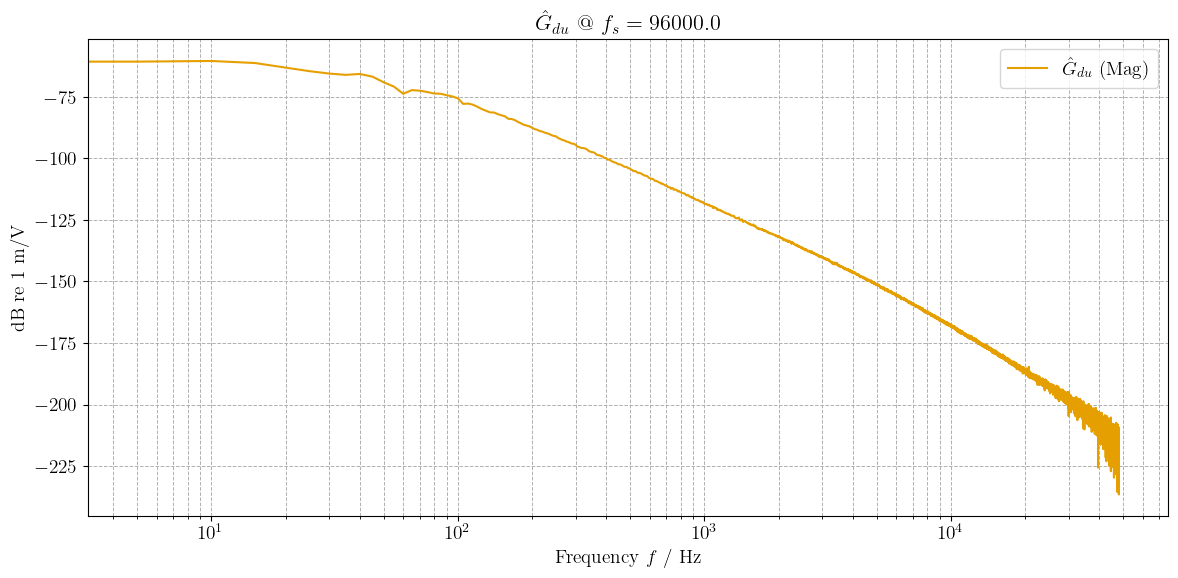

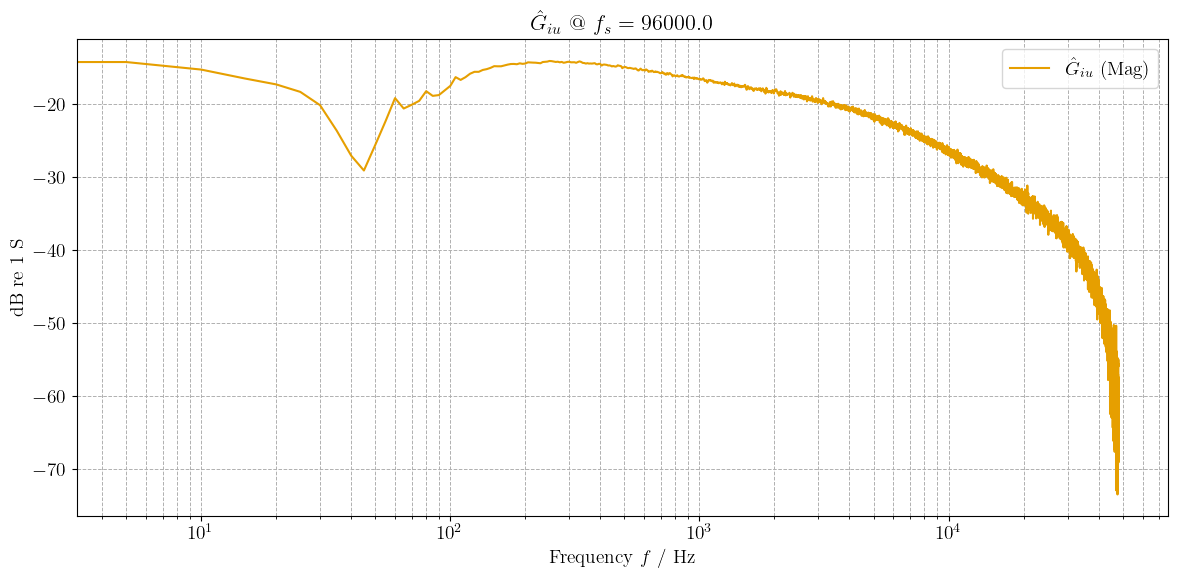

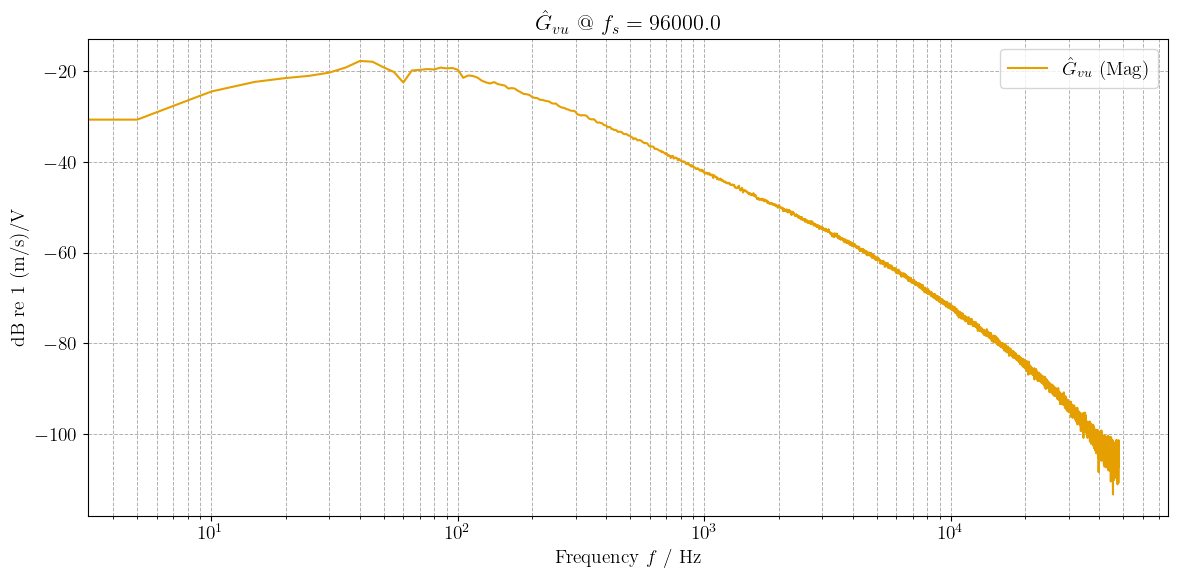

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
engutil = engutil.reload_self()
import util
import pandas as pd

data = pd.read_csv("data/part2a_presentation/01_nonlinear_full_1sec_at_96000.0.csv")

print(data.keys())
fs = 96e3

t = data["time"].to_numpy()
u = data["u"].to_numpy()
i = data["i"].to_numpy()
v = data["vel"].to_numpy()
d = data["disp"].to_numpy()
X = np.array([i,d,v])




G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

engutil.plot_bode(f, [(G_du_mag_db, None)], legends=["$\\hat{G}_{du}$"], title=f"$\\hat{{G}}_{{du}}$ @ $f_s = {fs}$", ylabel_left="dB re 1 m/V", save_loc="figures/part-2a/nonlinear-full/G_du")
engutil.plot_bode(f, [(G_iu_mag_db, None)], legends=["$\\hat{G}_{iu}$"], title=f"$\\hat{{G}}_{{iu}}$ @ $f_s = {fs}$", ylabel_left="dB re 1 S", save_loc="figures/part-2a/nonlinear-full/G_iu")
engutil.plot_bode(f, [(G_vu_mag_db, None)], legends=["$\\hat{G}_{vu}$"], title=f"$\\hat{{G}}_{{vu}}$ @ $f_s = {fs}$", ylabel_left="dB re 1 (m/s)/V", save_loc="figures/part-2a/nonlinear-full/G_vu")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 4 files. Processing...
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 01 Nonlinear Full
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 02 Nonlinear Stiffness Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 03 Nonlinear Bl Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 04 Nonlinear Le Only


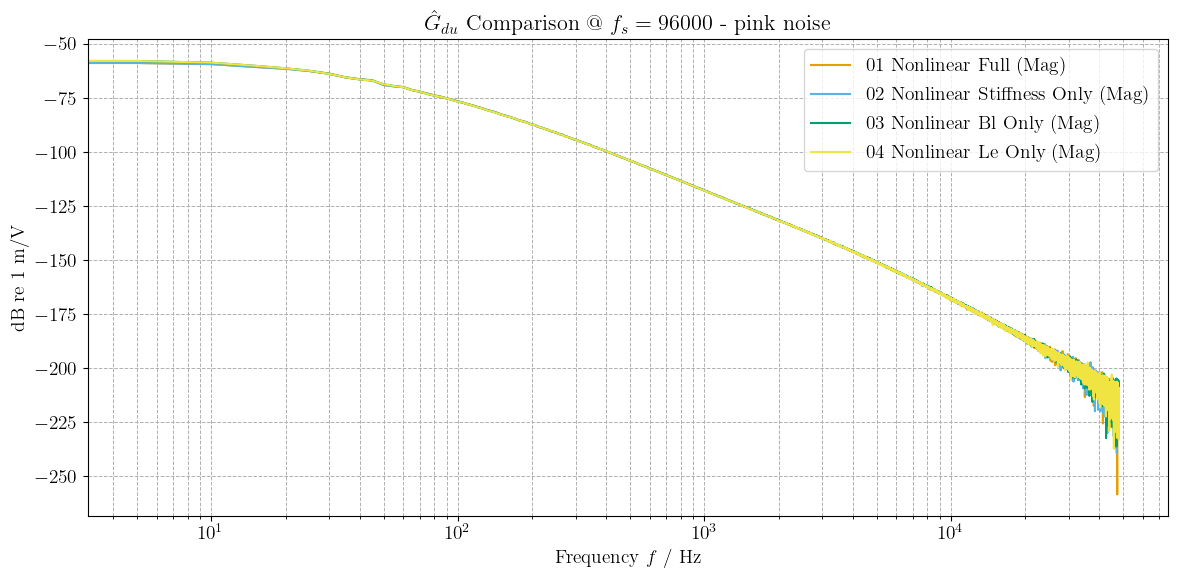

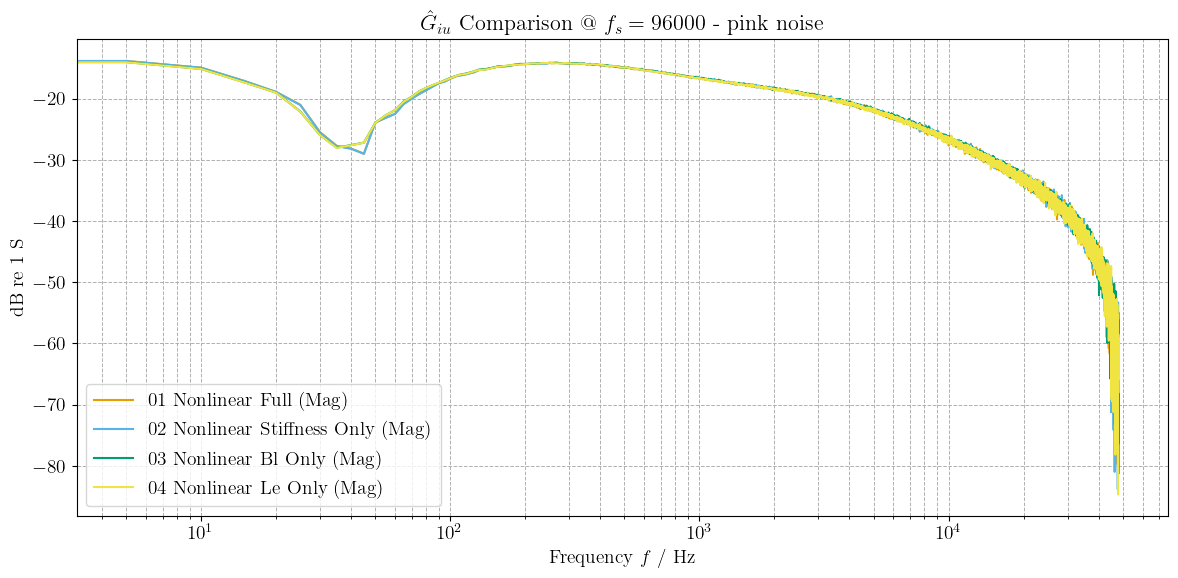

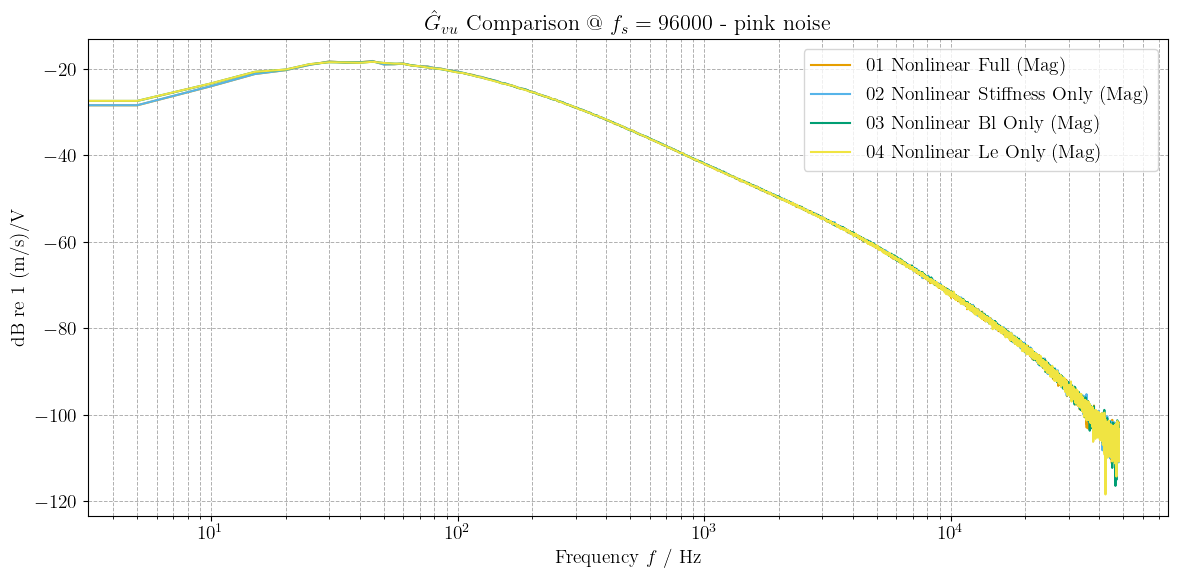

All plots generated.


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
import util
import pandas as pd
import glob
import os


## KLIPPEL
Z = klippel.load_klippel_impedance_tf("data/lab b/measurement 1 - linear/Magnitude of electric impedance Z(f).txt")
H = klippel.load_klippel_displacement_tf("data/lab b/measurement 1 - linear/Magnitude of transfer function Hx(f)= X(f)U(f).txt")

print(Z.keys())

f_H_measured = H["measured"]["frequency"].to_numpy()
Hmag_measured = H["measured"]["value"].to_numpy()
Hmag_fitted_wo_creep = H["fitted without creep"]["value"].to_numpy()
Hmag_fitted = H["measured"]["value"].to_numpy()

f_Z_measured = Z["measured"]["frequency"].to_numpy()
Zmag_measured = Z["measured"]["value"].to_numpy()
Zmag_fitted = Z["fitted"]["value"].to_numpy()


# --------------- KLIPPEL


# 1. Find all CSV files in the directory
input_dir = "data/part2a_presentation"
# Use sorted() to ensure they load in order (01, 02, 03, 04)
file_paths = sorted(glob.glob(os.path.join(input_dir, "*.csv")))

# 2. Prepare lists to store traces for plotting
# Each item in these lists will be a tuple: (magnitude_db, phase)
traces_G_iu = []
traces_G_du = []
traces_G_vu = []

legends = []

fs = 96e3
f_axis = None # Will store the frequency vector from the first file

print(f"Found {len(file_paths)} files. Processing...")

# 3. Loop through files
for file_path in file_paths:
    # --- A. Load Data ---
    data = pd.read_csv(file_path)
    
    # Generate a clean name for the legend
    # e.g., "01_nonlinear_full_1sec..." -> "01 Nonlinear Full"
    filename = os.path.basename(file_path)
    # Split by "_1sec" to remove the tail, replace underscores with spaces
    clean_name = filename.split("_1sec")[0].replace("_", " ").title() 
    legends.append(clean_name)
    
    # --- B. Extract Signals ---
    u = data["u"].to_numpy()
    i = data["i"].to_numpy()
    v = data["vel"].to_numpy()
    d = data["disp"].to_numpy()
    X = np.array([i, d, v])

    # --- C. Calculate Transfer Functions ---
    # Calculates all 3 TFs at once
    G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
    
    # Store frequency axis (only need to do this once)
    if f_axis is None:
        f_axis = f

    # --- D. Convert to Magnitude (dB) ---
    G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
    G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
    G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

    # --- E. Store for Plotting ---
    # engutil.plot_bode expects a list of tuples: [(mag, phase), (mag, phase), ...]
    # We pass None for phase since we aren't plotting it here
    traces_G_iu.append((G_iu_mag_db, None))
    traces_G_du.append((G_du_mag_db, None))
    traces_G_vu.append((G_vu_mag_db, None))

    print(f"Processed: {clean_name}")


# 4. Plot Everything Overlaid
# We pass the list of traces and the list of legends

# Plot G_du (Displacement)
engutil.plot_bode(
    f_axis, 
    traces_G_du, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{du}}$ Comparison @ $f_s = {int(fs)}$ - pink noise", 
    ylabel_left="dB re 1 m/V", 
    save_loc="figures/part-2a/comparison_G_du"
)

# Plot G_iu (Admittance)
engutil.plot_bode(
    f_axis, 
    traces_G_iu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{iu}}$ Comparison @ $f_s = {int(fs)}$  - pink noise", 
    ylabel_left="dB re 1 S", 
    save_loc="figures/part-2a/comparison_G_iu"
)

# Plot G_vu (Velocity)
engutil.plot_bode(
    f_axis, 
    traces_G_vu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{vu}}$ Comparison @ $f_s = {int(fs)}$ - pink noise", 
    ylabel_left="dB re 1 (m/s)/V", 
    save_loc="figures/part-2a/comparison_G_vu"
)

print("All plots generated.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 4 simulation files. Processing...
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 01 Nonlinear Full
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 02 Nonlinear Stiffness Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 03 Nonlinear Bl Only
len samples: 96000
nperseg = 19200.0
len seconds: 1.0
Processed: 04 Nonlinear Le Only
Loading Klippel Data...
Generating Plots...


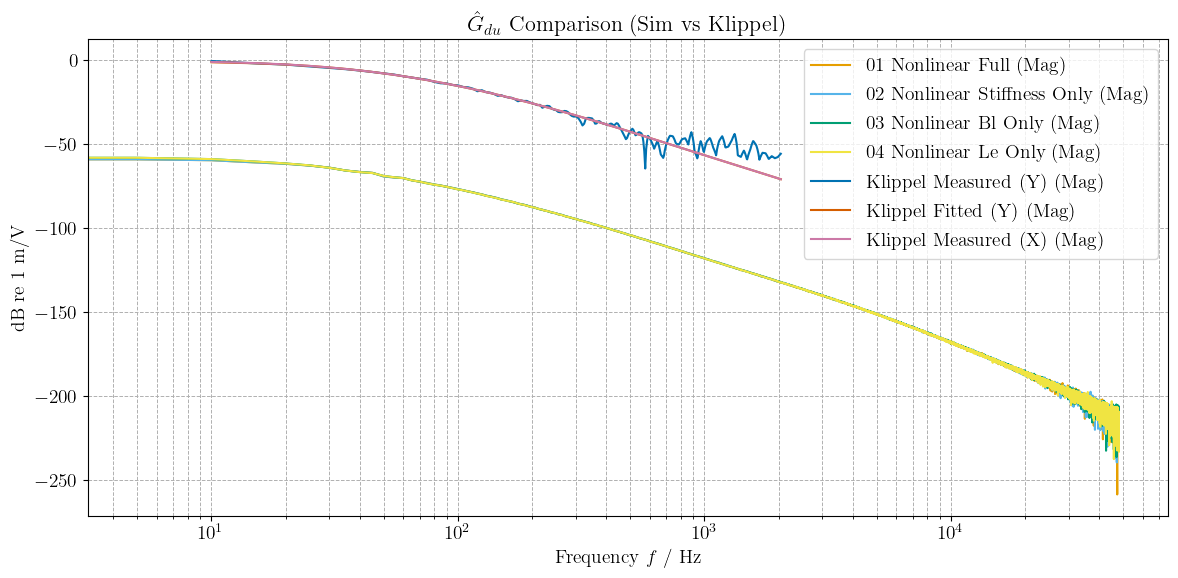

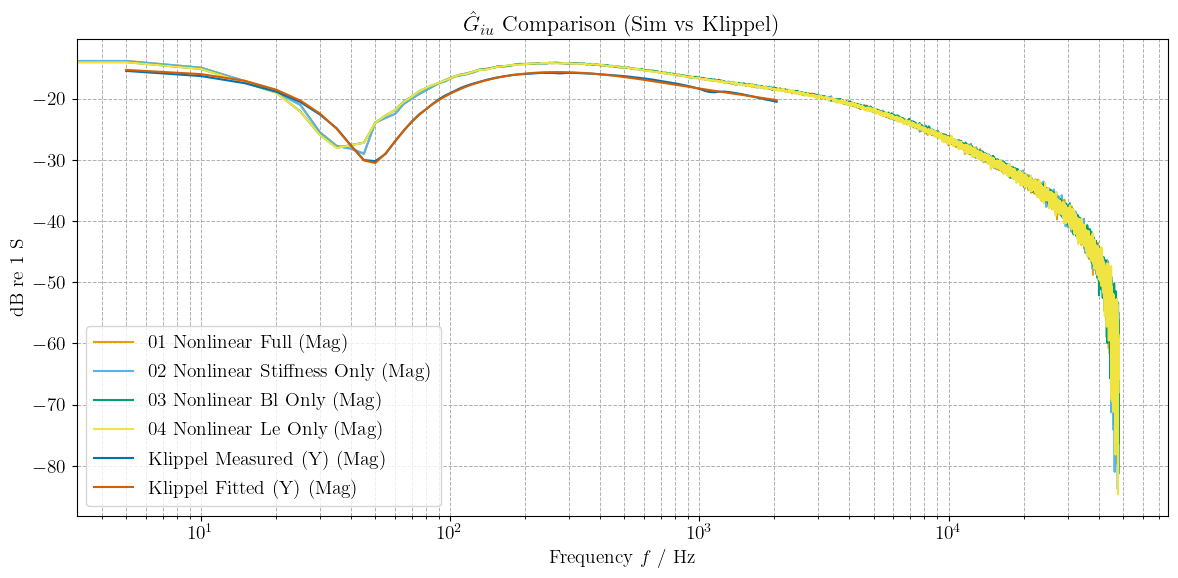

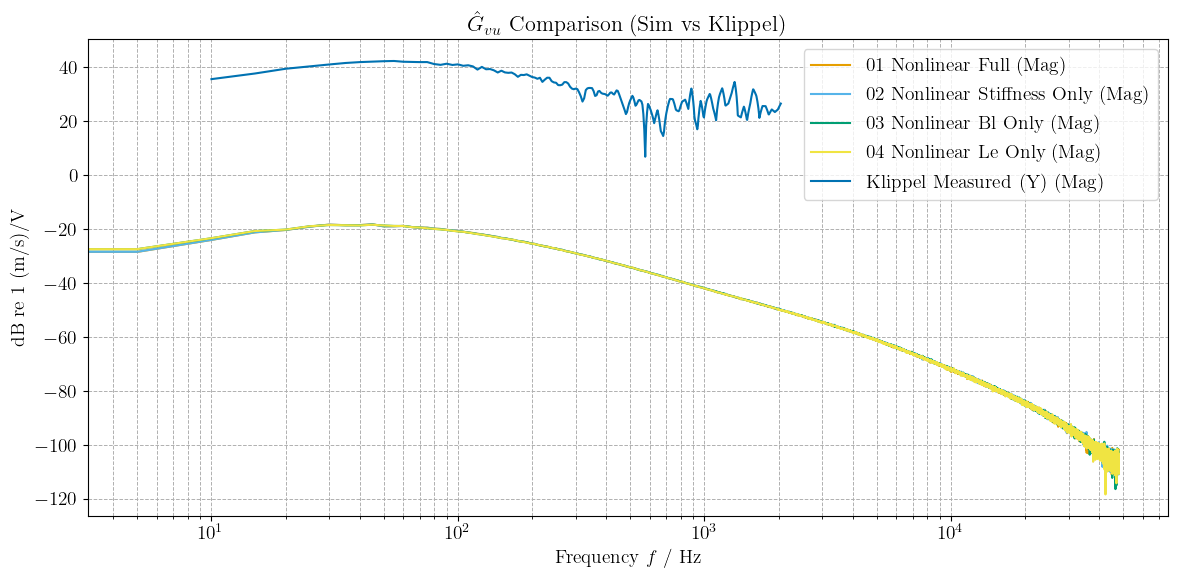

Done.


In [27]:
%load_ext autoreload
%autoreload 2
import numpy as np
import engutil
import util
import pandas as pd
import glob
import os
import klippel # Assuming you have this module

# --- 1. Setup & Simulation Loading ---
input_dir = "data/part2a_presentation"
file_paths = sorted(glob.glob(os.path.join(input_dir, "*.csv")))

traces_G_iu = []
traces_G_du = []
traces_G_vu = []
legends = []

fs = 96e3
f_axis = None 

print(f"Found {len(file_paths)} simulation files. Processing...")

for file_path in file_paths:
    # A. Load Data
    data = pd.read_csv(file_path)
    
    filename = os.path.basename(file_path)
    clean_name = filename.split("_1sec")[0].replace("_", " ").title() 
    legends.append(clean_name)
    
    # B. Extract Signals
    u = data["u"].to_numpy()
    i = data["i"].to_numpy()
    v = data["vel"].to_numpy()
    d = data["disp"].to_numpy()
    X = np.array([i, d, v])

    # C. Calculate Transfer Functions
    G_iu, G_du, G_vu, f = util.welchie(u, X, fs, numavgs=5)
    
    if f_axis is None:
        f_axis = f

    # D. Convert to Magnitude (dB)
    G_iu_mag_db, _, _ = engutil.tf_to_magphase(G_iu)
    G_du_mag_db, _, _ = engutil.tf_to_magphase(G_du)
    G_vu_mag_db, _, _ = engutil.tf_to_magphase(G_vu)

    # E. Store
    traces_G_iu.append((G_iu_mag_db, None))
    traces_G_du.append((G_du_mag_db, None))
    traces_G_vu.append((G_vu_mag_db, None))
    
    print(f"Processed: {clean_name}")

# --- 2. Load & Process Klippel Data ---
print("Loading Klippel Data...")

Z = klippel.load_klippel_impedance_tf("data/lab b/measurement 1 - linear/Magnitude of electric impedance Z(f).txt")
H = klippel.load_klippel_displacement_tf("data/lab b/measurement 1 - linear/Magnitude of transfer function Hx(f)= X(f)U(f).txt")

# Extract Klippel Arrays
f_Z_measured = Z["measured"]["frequency"].to_numpy()
Zmag_measured = Z["measured"]["value"].to_numpy()
Zmag_fitted = Z["fitted"]["value"].to_numpy()

f_H_measured = H["measured"]["frequency"].to_numpy()
Hmag_measured = H["measured"]["value"].to_numpy()
# Note: Assuming 'fitted without creep' exists in your dictionary, otherwise check keys
Hmag_fitted_wo_creep = H["fitted without creep"]["value"].to_numpy()
Hmag_fitted = H["fitted"]["value"].to_numpy() # Adjusted from your snippet (you had measured here)

# --- Helper Function for Interpolation & dB Conversion ---
def add_klippel_trace(f_target, f_src, val_src, dest_list, dest_legends, name, conversion_type="linear"):
    """
    Interpolates source data to f_target and converts to dB.
    conversion_type: 
      'linear' -> 20*log10(val)
      'impedance' -> -20*log10(val)  (Because we want Admittance 1/Z)
    """
    # 1. Interpolate onto the Simulation Frequency Axis
    # fill_value=np.nan ensures we don't draw lines outside the measured range
    val_interp = np.interp(f_target, f_src, val_src, left=np.nan, right=np.nan)
    
    # 2. Convert to dB
    if conversion_type == "impedance":
        # G_iu = 1/Z => dB = 20*log10(1/Z) = -20*log10(Z)
        val_db = -20 * np.log10(val_interp)
    else:
        # Standard Transfer Function
        val_db = 20 * np.log10(val_interp)
        
    # 3. Add to lists
    dest_list.append((val_db, None))
    dest_legends.append(name)

# --- 3. Add Klippel Data to Trace Lists ---

# Admittance Plot (G_iu)
# Note: We pass 'impedance' type to invert Z to Y
add_klippel_trace(f_axis, f_Z_measured, Zmag_measured, traces_G_iu, legends, "Klippel Measured (Y)", "impedance")
add_klippel_trace(f_axis, f_Z_measured, Zmag_fitted,   traces_G_iu, legends, "Klippel Fitted (Y)",   "impedance")

# Displacement Plot (G_du)
add_klippel_trace(f_axis, f_H_measured, Hmag_measured,        traces_G_du, legends, "Klippel Measured (X)", "linear")
add_klippel_trace(f_axis, f_H_measured, Hmag_fitted_wo_creep, traces_G_du, legends, "Klippel Fitted No Creep", "linear")
add_klippel_trace(f_axis, f_H_measured, Hmag_fitted,          traces_G_du, legends, "Klippel Fitted", "linear")

# Velocity Plot (G_vu)
# Klippel Hx is Displacement. To get Velocity, multiply by jw (or just +20dB/decade magnitude)
# Velocity = Displacement * 2*pi*f
# val_vel = Hmag * 2 * np.pi * f_src
# We calculate this specifically for the velocity plot
val_vel_measured = Hmag_measured * 2 * np.pi * f_H_measured
add_klippel_trace(f_axis, f_H_measured, val_vel_measured, traces_G_vu, legends, "Klippel Measured (V)", "linear")


# --- 4. Plotting ---

print("Generating Plots...")

# Plot G_du (Displacement)
engutil.plot_bode(
    f_axis, 
    traces_G_du, 
    legends=legends, # Note: legends list now includes simulation AND Klippel names
    title=f"$\\hat{{G}}_{{du}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 m/V", 
    save_loc="figures/part-2a/comparison_G_du_with_klippel"
)

# Plot G_iu (Admittance)
engutil.plot_bode(
    f_axis, 
    traces_G_iu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{iu}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 S", 
    save_loc="figures/part-2a/comparison_G_iu_with_klippel"
)

# Plot G_vu (Velocity)
engutil.plot_bode(
    f_axis, 
    traces_G_vu, 
    legends=legends, 
    title=f"$\\hat{{G}}_{{vu}}$ Comparison (Sim vs Klippel)", 
    ylabel_left="dB re 1 (m/s)/V", 
    save_loc="figures/part-2a/comparison_G_vu_with_klippel"
)

print("Done.")

In [5]:
import numpy as np
X_saved= np.array([x_history[:,0], x_history[:,1], x_history[:,2], x_history[:,3]])

np.savetxt("duration_5_sec_min_fs_5x.txt", X_saved)

## Plot of non linear params $Bl(x), K_m(x), L_e(x)$

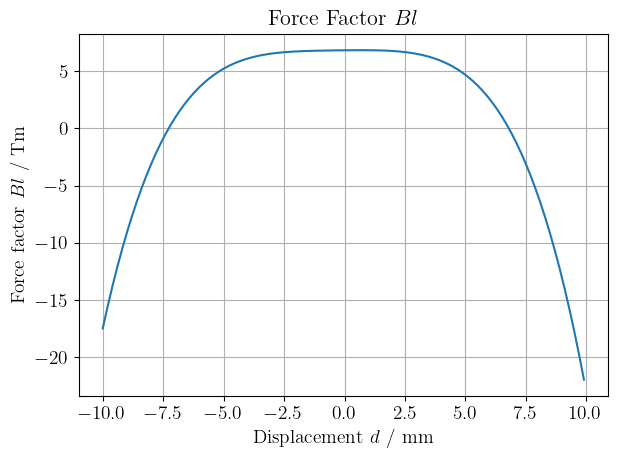

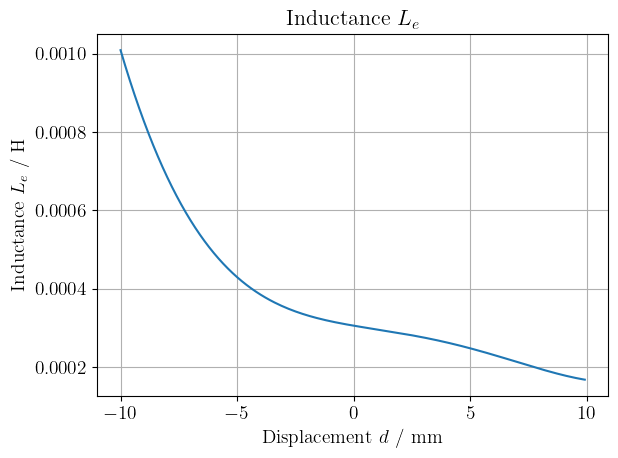

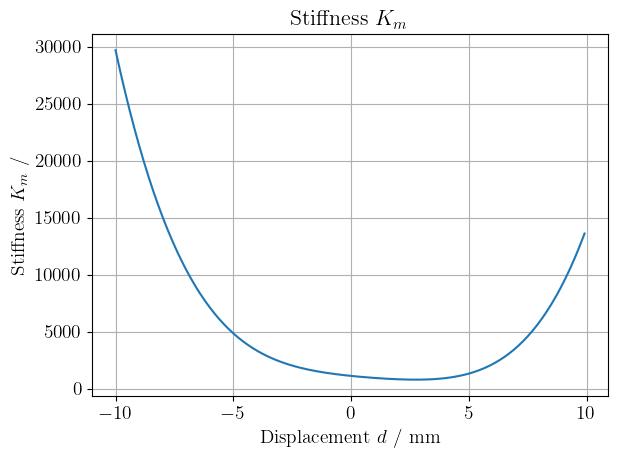

In [29]:

# setup params
Bl = 6.837193705842441
R_e = 4.822146670305587
R_m = 2.2833222074164836
K_m = 1107.8705431240523
L_e0 = 0.000305207582223968
M_m = 0.020004906958875274
L_20 = 0.0004325286577462285
R_20 = 2.504536634680621

Bln = [-2615563718.9455967, -3023090.98130258, -9835.616494456142, 21.171849188494026, Bl]
Kn  = [1724760519892.831, -5658865945.33859, 35715360.4027017, -210546.86882586573, K_m]
Ln  = [20081.188591764963, -319.17779393260366, 0.8155679039802962, -0.01018945289267653, L_e0]
Li  = [-0.0012237427320541485, -0.0014189369785025077, 0.007354393550658496, 0.005954177167801685, 1]

poly_Bl = np.poly1d(Bln)
poly_K = np.poly1d(Kn)
poly_Le = np.poly1d(Ln)*np.poly1d(Li)

x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Bl(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Force factor $Bl$ / Tm", xlabel="Displacement $d$ / mm", title="Force Factor $Bl$", save_loc="figures/force_factor", grid=True)

x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_Le(x) # poly_li
engutil.plot_time_series([(x*1e3,y)], ylabel="Inductance $L_e$ / H", xlabel="Displacement $d$ / mm", title="Inductance $L_e$", save_loc="figures/inductance", grid=True)


x = np.arange(-10e-3, 10e-3, 1e-4)
y = poly_K(x)
engutil.plot_time_series([(x*1e3,y)], ylabel="Stiffness $K_m$ / ", xlabel="Displacement $d$ / mm", title="Stiffness $K_m$", save_loc="figures/stiffness", grid=True)

